In [88]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr, spearmanr, kendalltau 
from scipy import stats

from robustDA import process_cmip6, processing, anchor_regression, plots, parse_args

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [89]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": 1000,
        "h_anchors": {},
    }

In [90]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [237]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [238]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

['AWI' 'CES' 'CIE' 'Can' 'E3S' 'FIO' 'GFD' 'IIT' 'INM' 'KIO' 'MIR' 'MPI'
 'NES' 'Tai']
['ACC' 'BCC' 'CAM' 'CAS' 'CMC' 'EC-' 'FGO' 'GIS' 'IPS' 'MCM' 'MRI' 'Nor'
 'SAM']


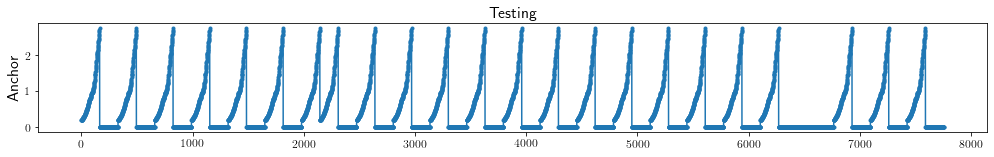

In [249]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_anchor_test.values, '.-')
plt.ylabel("Anchor")
plt.title("Testing");

In [246]:
lambdaSel, mse_df, corr_pearson, mi, lambdasCV = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    deepcopy(dict_models),
    params_climate,
    gamma,
    h_anchors,
    30,
    sel_method="multipleMSE",
    display_CV_plot=True)

In [247]:
lambdaSel

array([0.23950266, 1.61026203, 5.73615251])

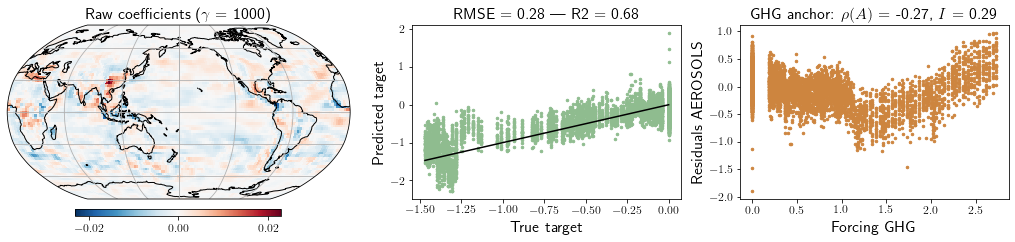

In [248]:
coefRaw, y_test_pred, mse = anchor_regression.anchor_regression_estimator(
    dict_models, gamma, h_anchors, lambdaSel[2])
anchor_regression.make_plots(dict_models, coefRaw, y_test_pred, dict_models["y_anchor_test"],
        gamma, params_climate["target"], params_climate["anchor"], h_anchors)

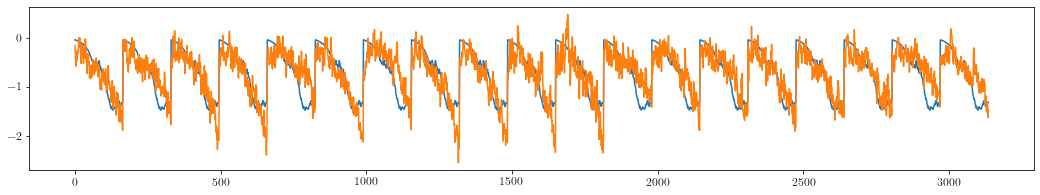

In [232]:
fig = plt.figure(figsize = (18, 3))
plt.plot(y_test.values)
plt.plot(y_test_pred)

In [226]:
X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

# Create a scaler object
sc_X = StandardScaler(with_mean=True, with_std=True)
sc_y = StandardScaler(with_mean=True, with_std=True)
sc_X_test = StandardScaler(with_mean=True, with_std=True)
sc_y_test = StandardScaler(with_mean=True, with_std=True)

# Fit the scaler to the data and transform
X_train_std = sc_X.fit_transform(X_train.values)
y_train_std = sc_y.fit_transform(y_train.values)
X_test_std = sc_X_test.fit_transform(X_test.values)
y_test_std = sc_y_test.fit_transform(y_test.values)

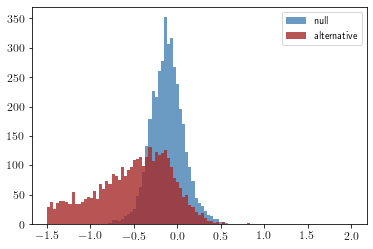

In [250]:
y_null = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] == "piControl":
        y_null = np.concatenate((y_null, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
y_alt = np.array([]).reshape(-1,1)
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1
for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] != "piControl":
        y_alt = np.concatenate((y_alt, y_test_pred[i * nbYears + 1: (i+1) * nbYears]))
        
bins = np.linspace(-1.5, 2, 100)
plt.hist(y_null, bins, alpha = 0.8, color = "steelblue", label = 'null');
plt.hist(y_alt, bins, alpha = 0.8, color = "brown", label = 'alternative');
plt.legend();

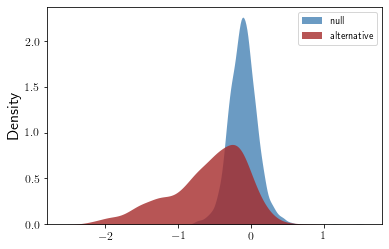

In [251]:
sns.kdeplot(y_null.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "steelblue", label = "null");
sns.kdeplot(y_alt.reshape(-1), fill = True, alpha=.8, linewidth=0, color = "brown", label = "alternative");
plt.legend();

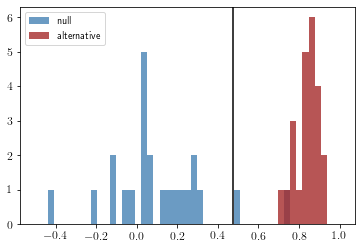

In [252]:
yf = process_cmip6.read_forcing_cmip6("historical", target, startDate, endDate)

ts_null = []
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1

for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] == "piControl":
        ts_null.append(np.corrcoef(np.transpose(y_test_pred[i * nbYears: (i+1) * nbYears]), 
                        np.transpose(yf.values.reshape(-1,1)))[0, 1])
        
ts_alt = []
nbYears = params_climate["endDate"] - params_climate["startDate"] + 1

for i in range(len(dict_models["testFiles"])):
    if dict_models["testFiles"][i].split("_")[3] != "piControl":
        ts_alt.append(np.corrcoef(np.transpose(y_test_pred[i * nbYears: (i+1) * nbYears]), 
                        np.transpose(yf.values.reshape(-1,1)))[0, 1])
        
bins = np.linspace(-0.5, 1, 50)
plt.hist(ts_null, bins, alpha = 0.8, color = "steelblue", label = 'null');
plt.hist(ts_alt, bins, alpha = 0.8, color = "brown", label = 'alternative');
plt.axvline(np.quantile(ts_null, q = 0.95), 0, 1.4, color = 'k')
plt.legend();

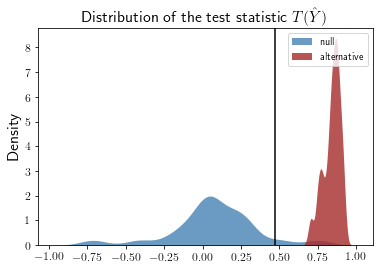

In [256]:
sns.kdeplot(ts_null, bw_method = 0.3, fill = True, color = "steelblue", alpha=.8, linewidth=0, label = "null");
sns.kdeplot(ts_alt, bw_method = 0.3, fill = True, color = "brown", alpha=.8, linewidth=0, label = "alternative");
plt.axvline(np.quantile(ts_null, q = 0.95), 0, 1.4, color = 'k')
plt.xlabel("")
plt.title("Distribution of the test statistic $T(\hat{Y})$")
# plt.yscale("log")
plt.legend();

In [91]:
import pickle
filename = ("./../output/data/subagging_" + target + "_" + anchor + "_gamma_" + str(gamma) + "_square_noAhstd.pkl")
with open(filename, 'rb') as f:
    lambdaSel_runs, coefRaw_runs, mse_runs_df, corr_pearson_runs, mi_runs, y_test_pred_runs, \
            ts_null, ts_alt = pickle.load(f)

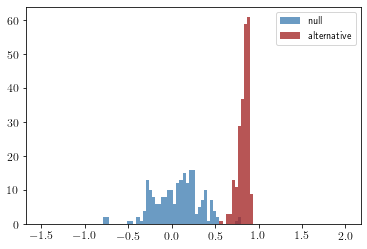

In [92]:
bins = np.linspace(-1.5, 2, 100)
plt.hist(ts_null, bins, alpha = 0.8, color = "steelblue", label = 'null');
plt.hist(ts_alt, bins, alpha = 0.8, color = "brown", label = 'alternative');
plt.legend();

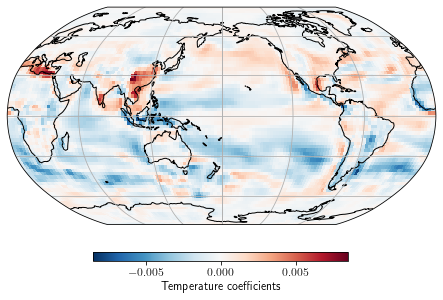

In [93]:
plots.plotMapCartopy(coefRaw_runs[0,:].reshape((72,144)), cLim = None)

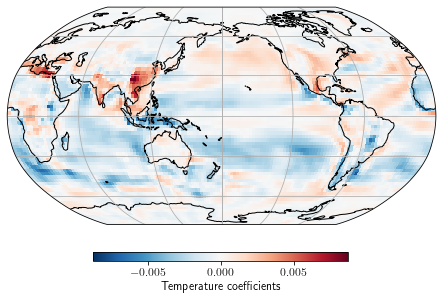

In [94]:
plots.plotMapCartopy(np.mean(coefRaw_runs, 0).reshape((72,144)), cLim = None)

In [95]:
lambdaSel_runs

array([[20.43359718],
       [10.82636734],
       [20.43359718],
       [20.43359718],
       [20.43359718],
       [38.56620421],
       [20.43359718],
       [38.56620421],
       [20.43359718],
       [20.43359718]])

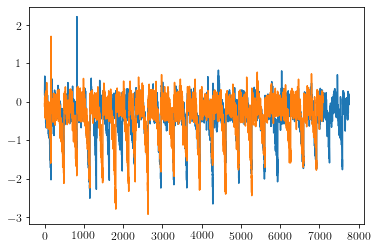

In [97]:
plt.plot(np.asarray(y_test_pred_runs[0]).reshape(-1))
plt.plot(np.asarray(y_test_pred_runs[1]).reshape(-1))